# Quick look at Sea Ice Volume
- No observations (thickness plots coming)
- Compare to OM2
- Can merged with sea ice area timeseries in the future

In [1]:
#parameters

### USER EDIT start
# esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
esm_file='/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json
Plot folder path:  /g/data/tm70/as2285/access-om3-paper-figs/


In [2]:
import xarray as xr
import numpy as np
import cf_xarray
from datetime import timedelta
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client

import pandas as pd
pd.set_option('display.max_rows', 500)

In [3]:
IAF = esm_file.find('iaf') > 0
IAF

True

In [4]:
if IAF:
    om2_exp = '025deg_jra55_iaf_omip2_cycle6'
else:
    om2_exp = '025deg_jra55_ryf9091_gadi'

In [5]:
client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

### Open the intake-esm datastore

In [6]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)

### What ocean variables are available at monthly frequency?

In [7]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

### Load ACCESS-OM3 sea ice mass budget

In [8]:
variables = ["hi_m", "hs_m"]
ds = datastore.search(variable=variables, frequency="1mon").to_dask(
    xarray_open_kwargs = dict(chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
                              decode_timedelta=True,),
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


Load grid cell area from cice variable

In [9]:
tarea = datastore.search(frequency="fx", realm="seaIce").to_dask().compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


Integrate terms for both poles. The terms are currently in cm/day, so convert to m/day 

In [34]:
antarctic_seaice = (ds * tarea.tarea ).sel(nj=slice(0,int(len(ds.nj)/2))).sum(['nj','ni'])
arctic_seaice = (ds * tarea.tarea ).sel(nj=slice(int(len(ds.nj)/2), None)).sum(['nj','ni'])

### Load ACCESS-OM2

In [11]:
catalog = intake.cat.access_nri

In [12]:
var = catalog[om2_exp].search(variable=variables,frequency="1mon")
var.esmcat.aggregation_control.groupby_attrs = ['frequency']  ## Not sure why I have to do this!!
ds_om2=var.to_dask(xarray_open_kwargs=dict(chunks={"time": -1},
                                                   decode_timedelta=True,
                                                   ), 
                           xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override", data_vars="minimal", coords="minimal",),                          
)

# shift time to correct for OM2 calendar strangeness
def shift_time(ds):
    ds["time"] = ds.time.to_pandas() - timedelta(minutes=1)
    return ds

ds_om2 = shift_time(ds_om2)


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [13]:
print(ds_om2.time.min().values, ds_om2.time.max().values)

1958-01-31T23:59:00.000000000 2018-12-31T23:59:00.000000000


Load grid cell area variable

In [14]:
var = catalog['025deg_jra55_ryf9091_gadi'].search(variable='tarea', frequency="1mon", start_date='1940-01-01.*')
ds_om2_tarea = var.to_dask()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


Integrate terms for both poles. The terms are currently in cm/day. 

In [15]:
antarctic_seaice_om2 = (ds_om2 * ds_om2_tarea.tarea ).sel(nj=slice(0,int(len(ds_om2.nj)/2))).sum(['nj','ni'])
arctic_seaice_om2 = (ds_om2 * ds_om2_tarea.tarea ).sel(nj=slice(int(len(ds_om2.nj)/2), None)).sum(['nj','ni'])

# Sea Ice Volume timeseries

Text(0.5, 1.0, 'Antarctic Snow Volume')

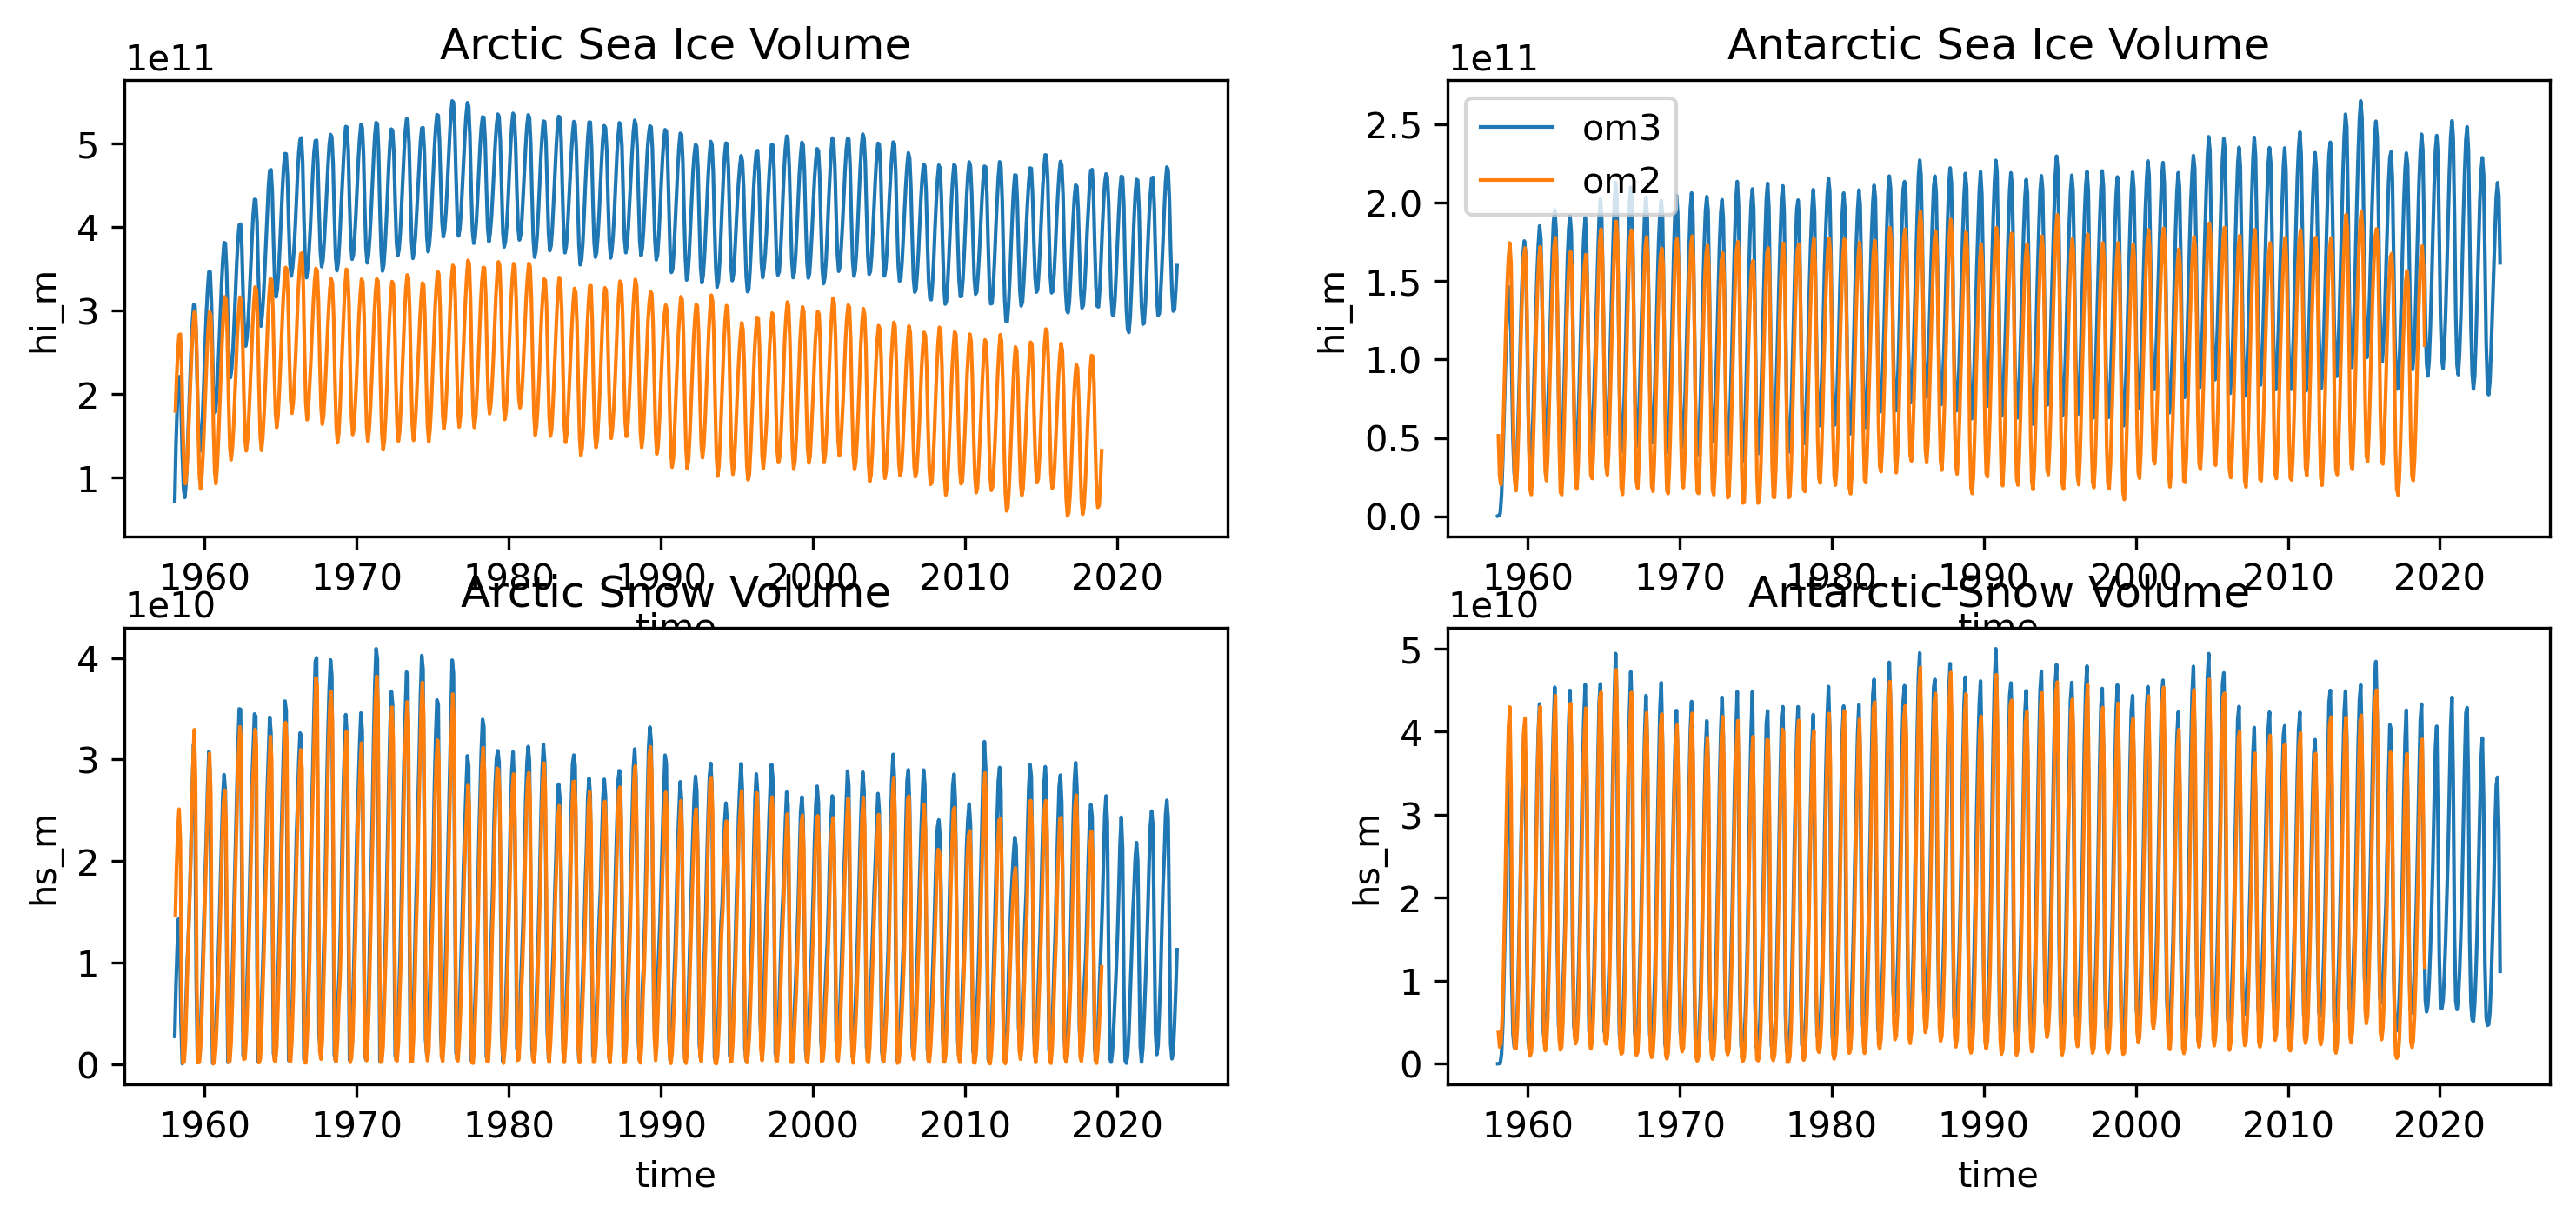

In [20]:
plt.figure(figsize=(12,5))

plt.subplot(2,2,1)
arctic_seaice.hi_m.plot(linewidth=1)
arctic_seaice_om2.hi_m.plot(linewidth=1)
plt.title('Arctic Sea Ice Volume')

plt.subplot(2,2,2)
antarctic_seaice.hi_m.plot(linewidth=1, label='om3')
antarctic_seaice_om2.hi_m.plot(linewidth=1, label='om2')
plt.legend()
plt.title('Antarctic Sea Ice Volume')

plt.subplot(2,2,3)
arctic_seaice.hs_m.plot(linewidth=1)
arctic_seaice_om2.hs_m.plot(linewidth=1)
plt.title('Arctic Snow Volume')

plt.subplot(2,2,4)
antarctic_seaice.hs_m.plot(linewidth=1)
antarctic_seaice_om2.hs_m.plot(linewidth=1)
plt.title('Antarctic Snow Volume')

# Volume (per cell) maps

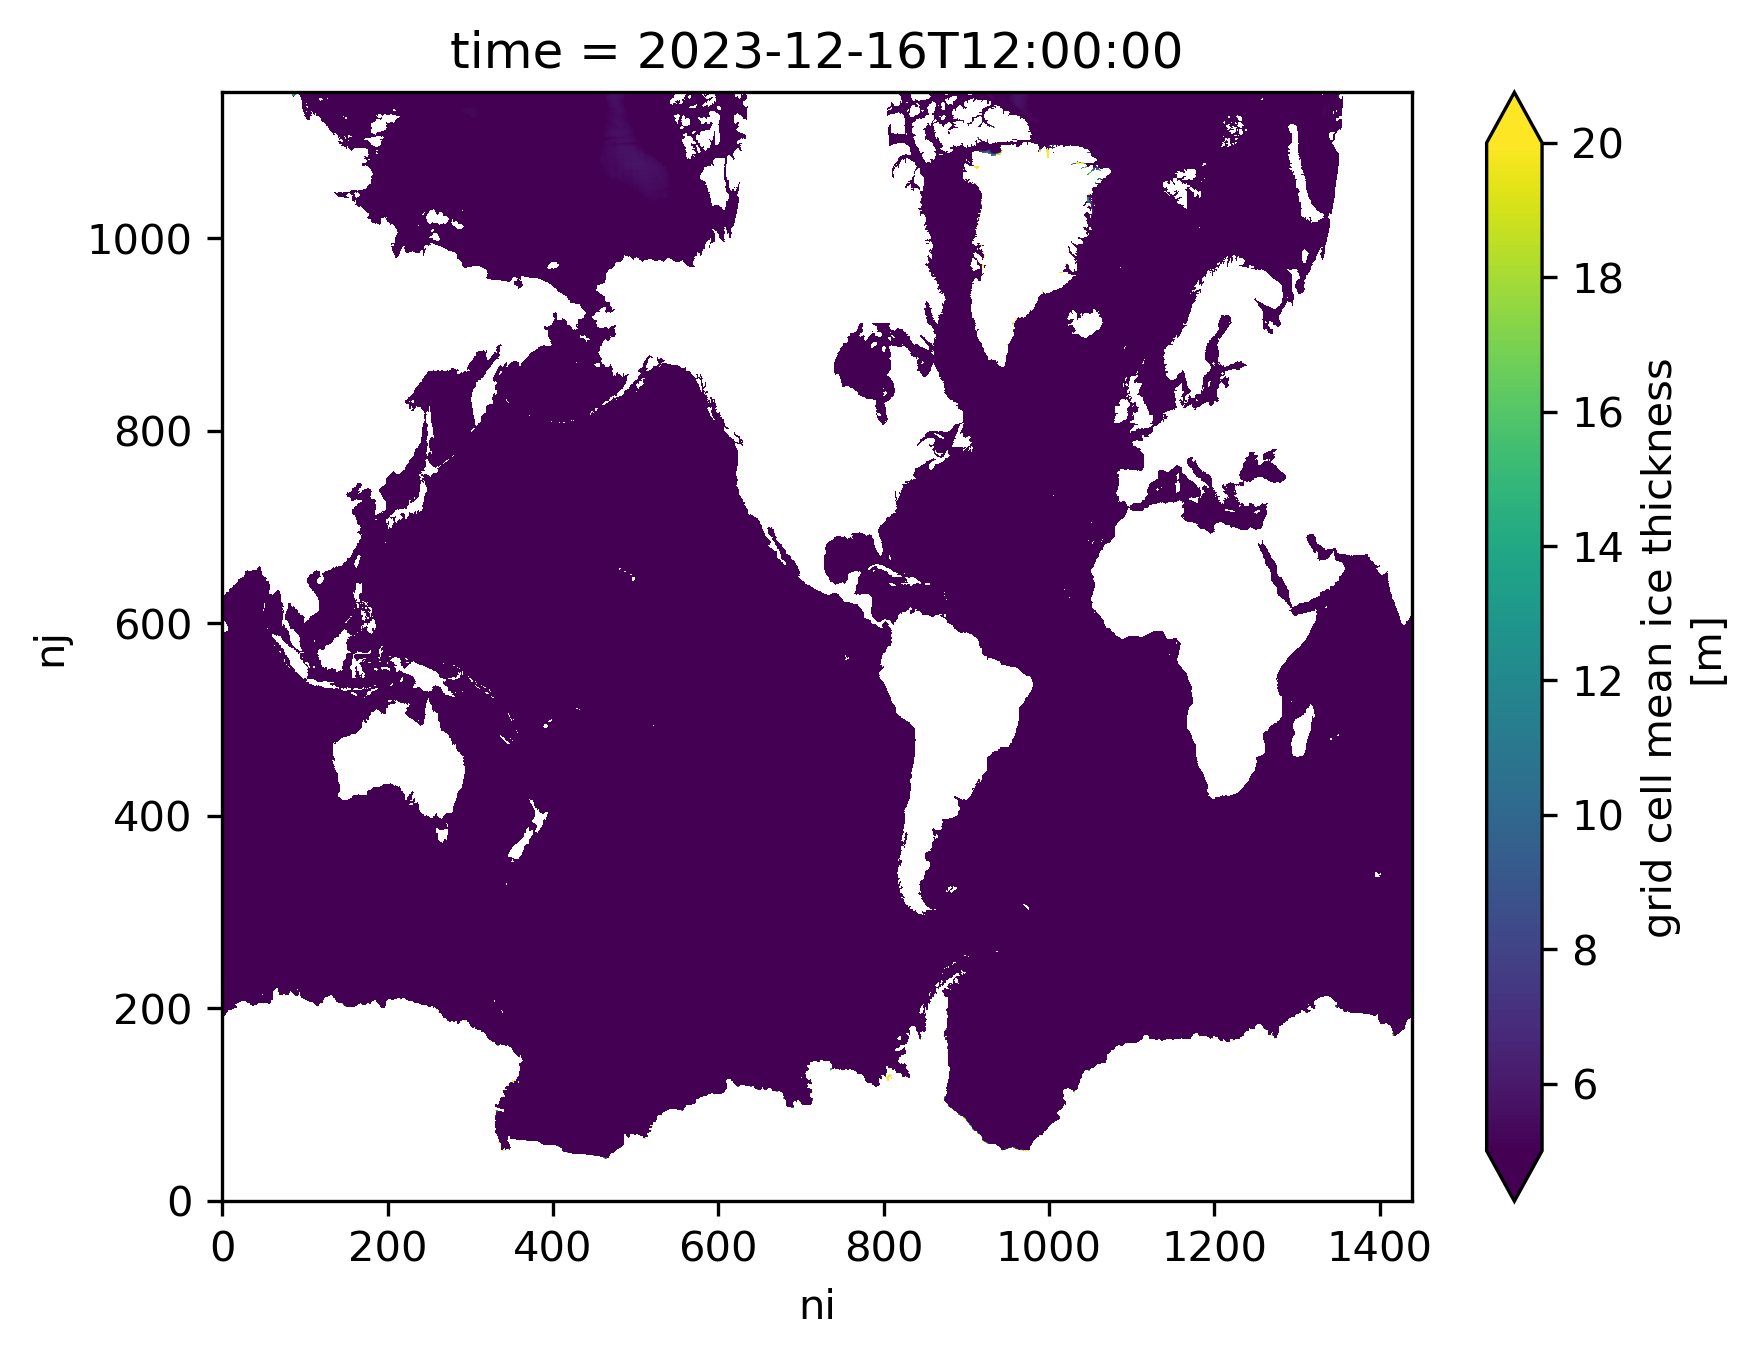

In [25]:
ds.hi_m.isel(time=-1).plot(vmin=5, vmax=20)

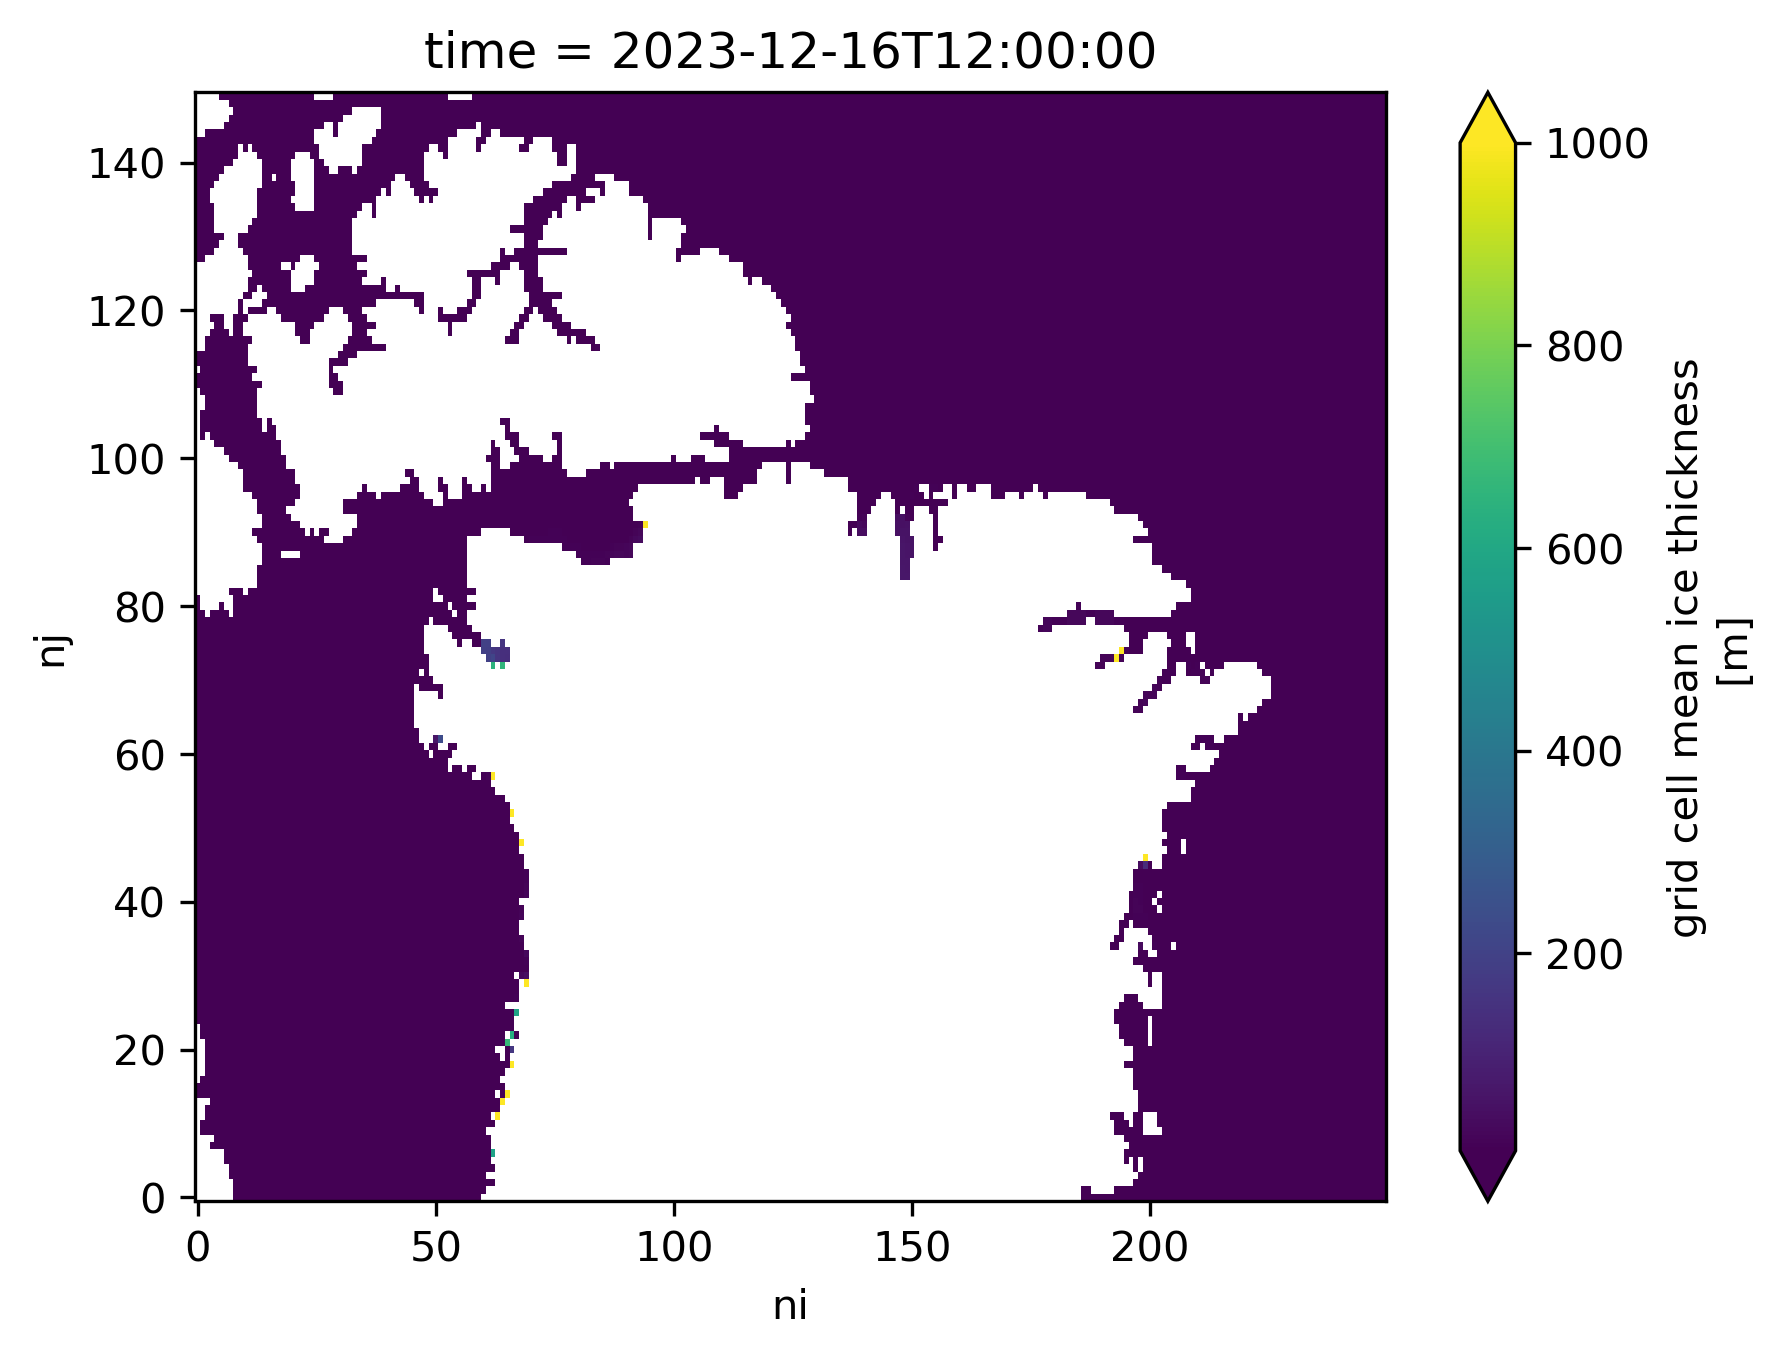

In [33]:
ds.hi_m.isel(time=-1, ni=slice(850,1100), nj=slice(1000,1150)).plot(vmin=5, vmax=1000)

In [ ]:
(ds.hi_m.where(ds.hi_m<20) * tarea.tarea ).sel(nj=slice(int(len(ds.nj)/2), None)).sum(['nj','ni']).plot(linewidth=1)
arctic_seaice.hi_m.plot(linewidth=1)


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.40 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.39 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [17]:
client.close()

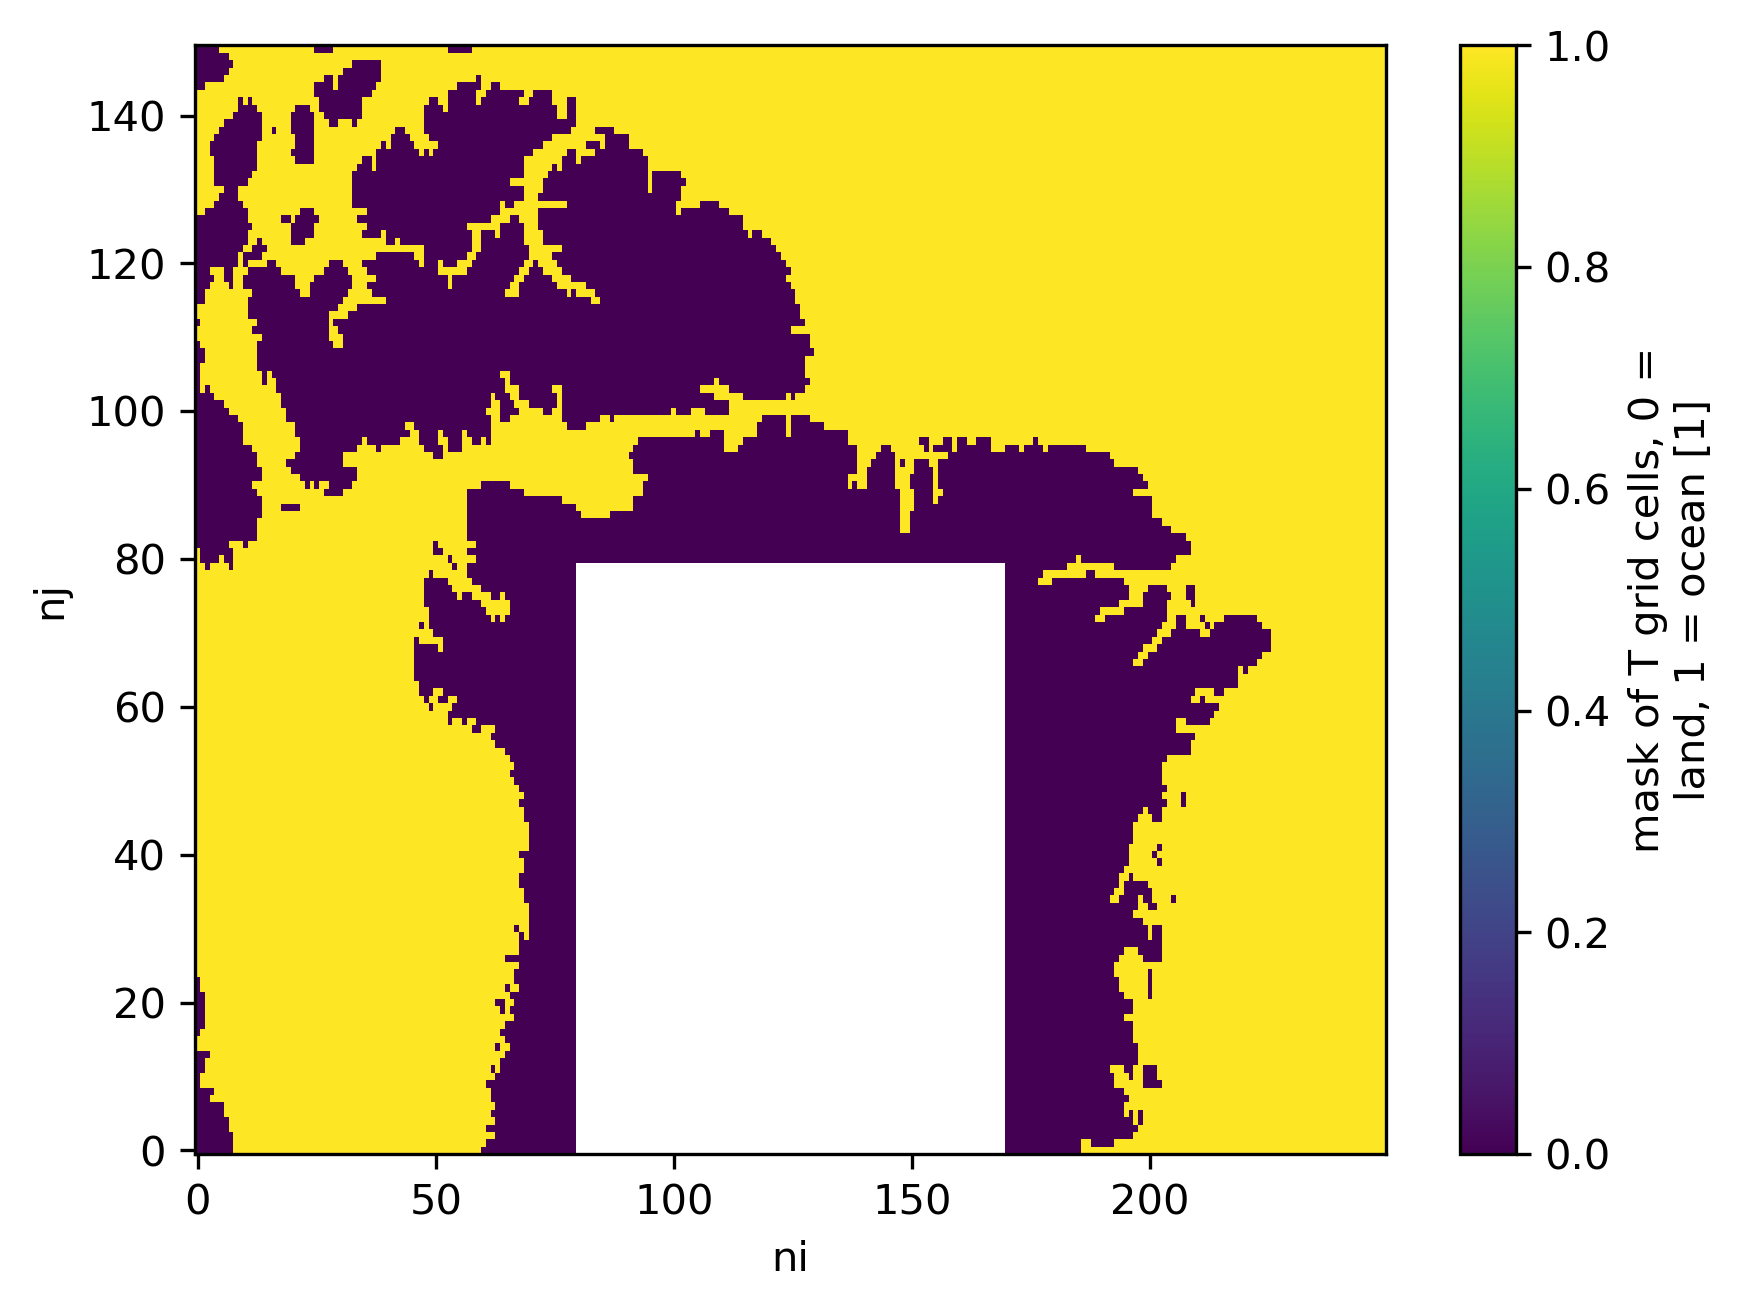

In [14]:
tarea.tmask.isel(ni=slice(850,1100), nj=slice(1000,1150)).plot()

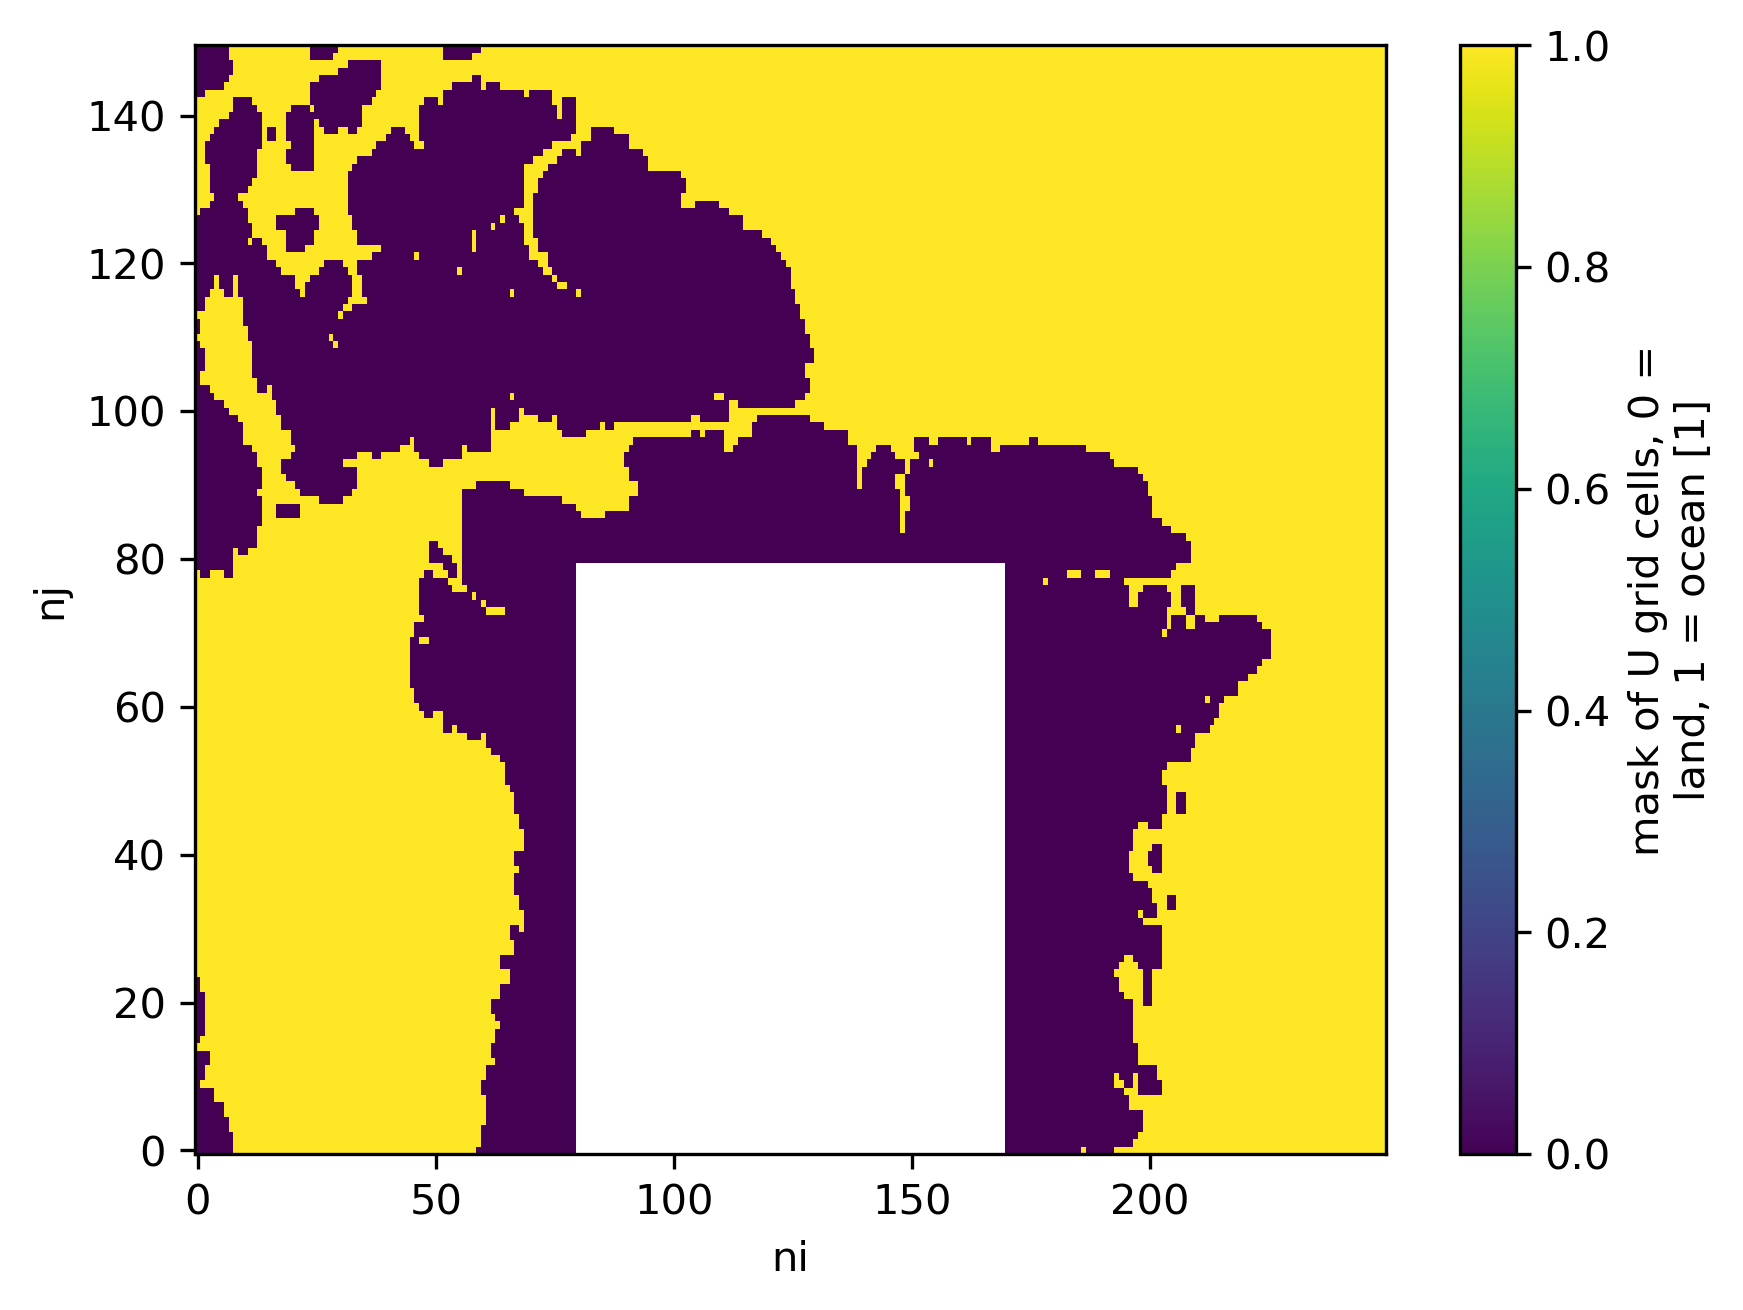

In [13]:
tarea.umask.isel(ni=slice(850,1100), nj=slice(1000,1150)).plot()

Text(0.5, 1.0, 'tmask+umask')

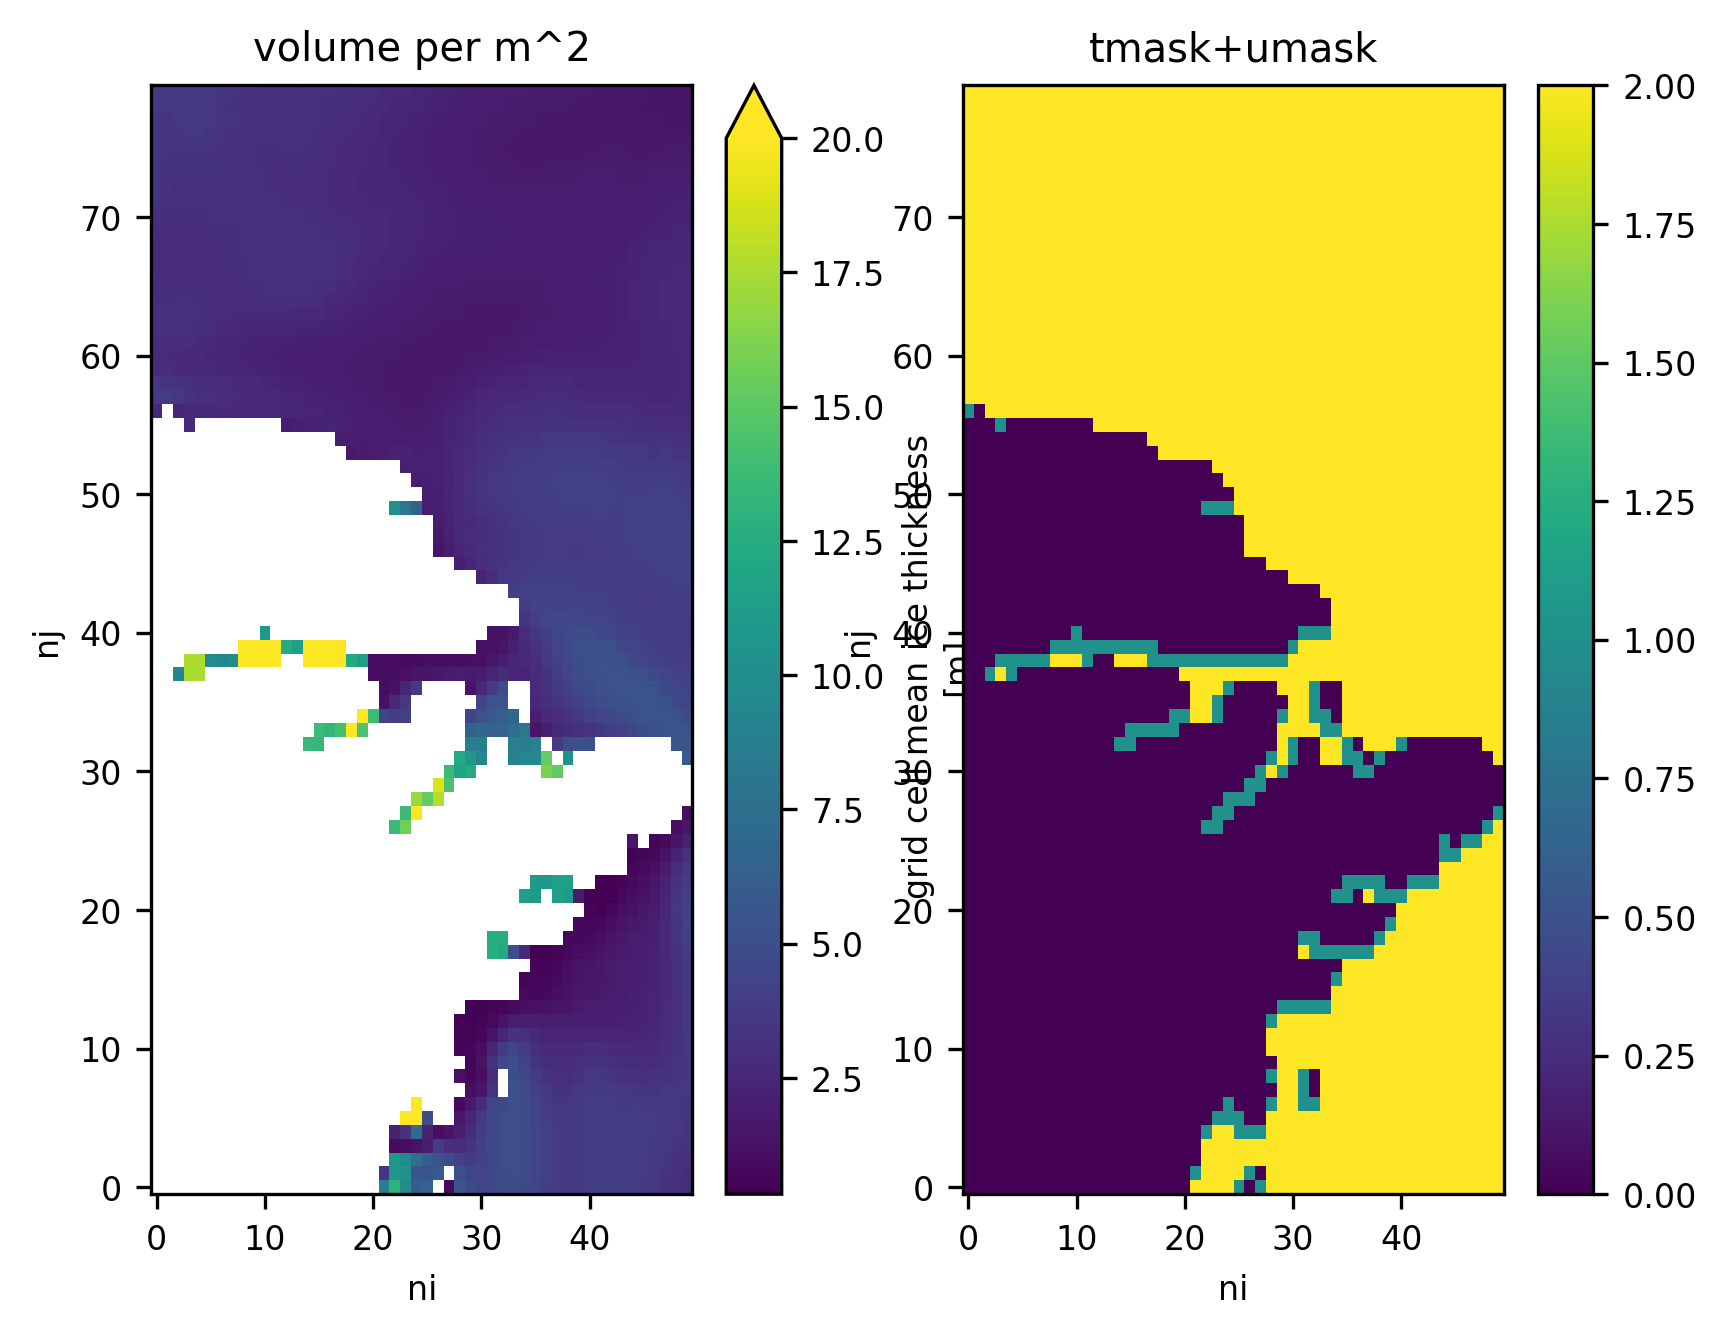

In [40]:
plt.rcParams['font.size'] = 8
plt.subplot(1,2,1)
ds.hi_m.isel(time=-1,ni=slice(1025,1075), nj=slice(1040,1120)).plot(vmax=20)
plt.title('volume per m^2')

plt.subplot(1,2,2)
(tarea.tmask+tarea.umask).isel(ni=slice(1025,1075), nj=slice(1040,1120)).plot()
plt.title('tmask+umask')

In [32]:
ocean_temp = datastore.search(variable='tos').to_dask()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 34.53 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


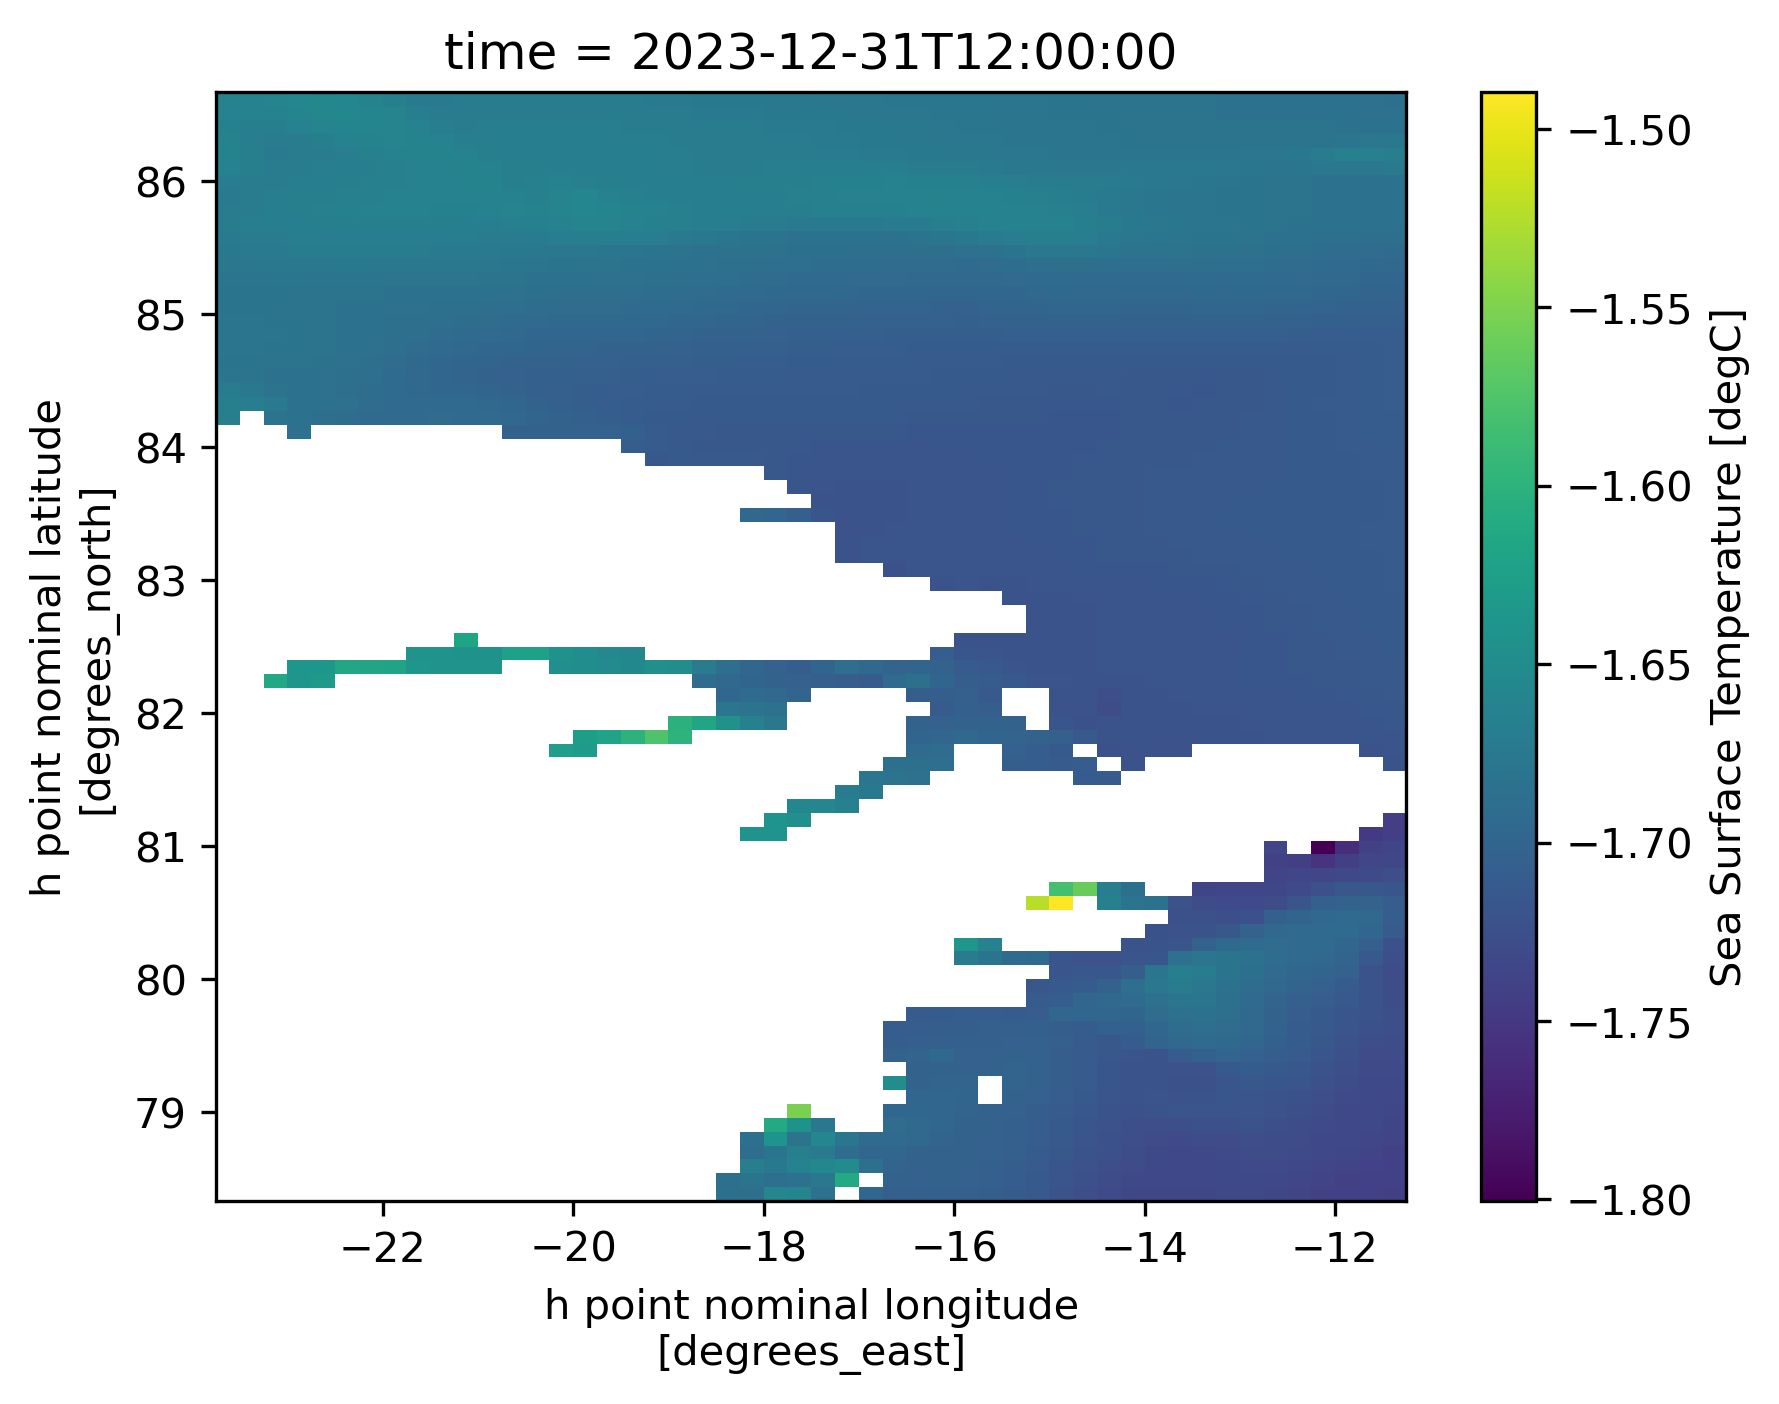

In [33]:
ocean_temp.tos.isel(time=-1, xh=slice(1025,1075), yh=slice(1040,1120)).plot()

In [29]:
ocean_salt = datastore.search(variable='sos').to_dask()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 34.53 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


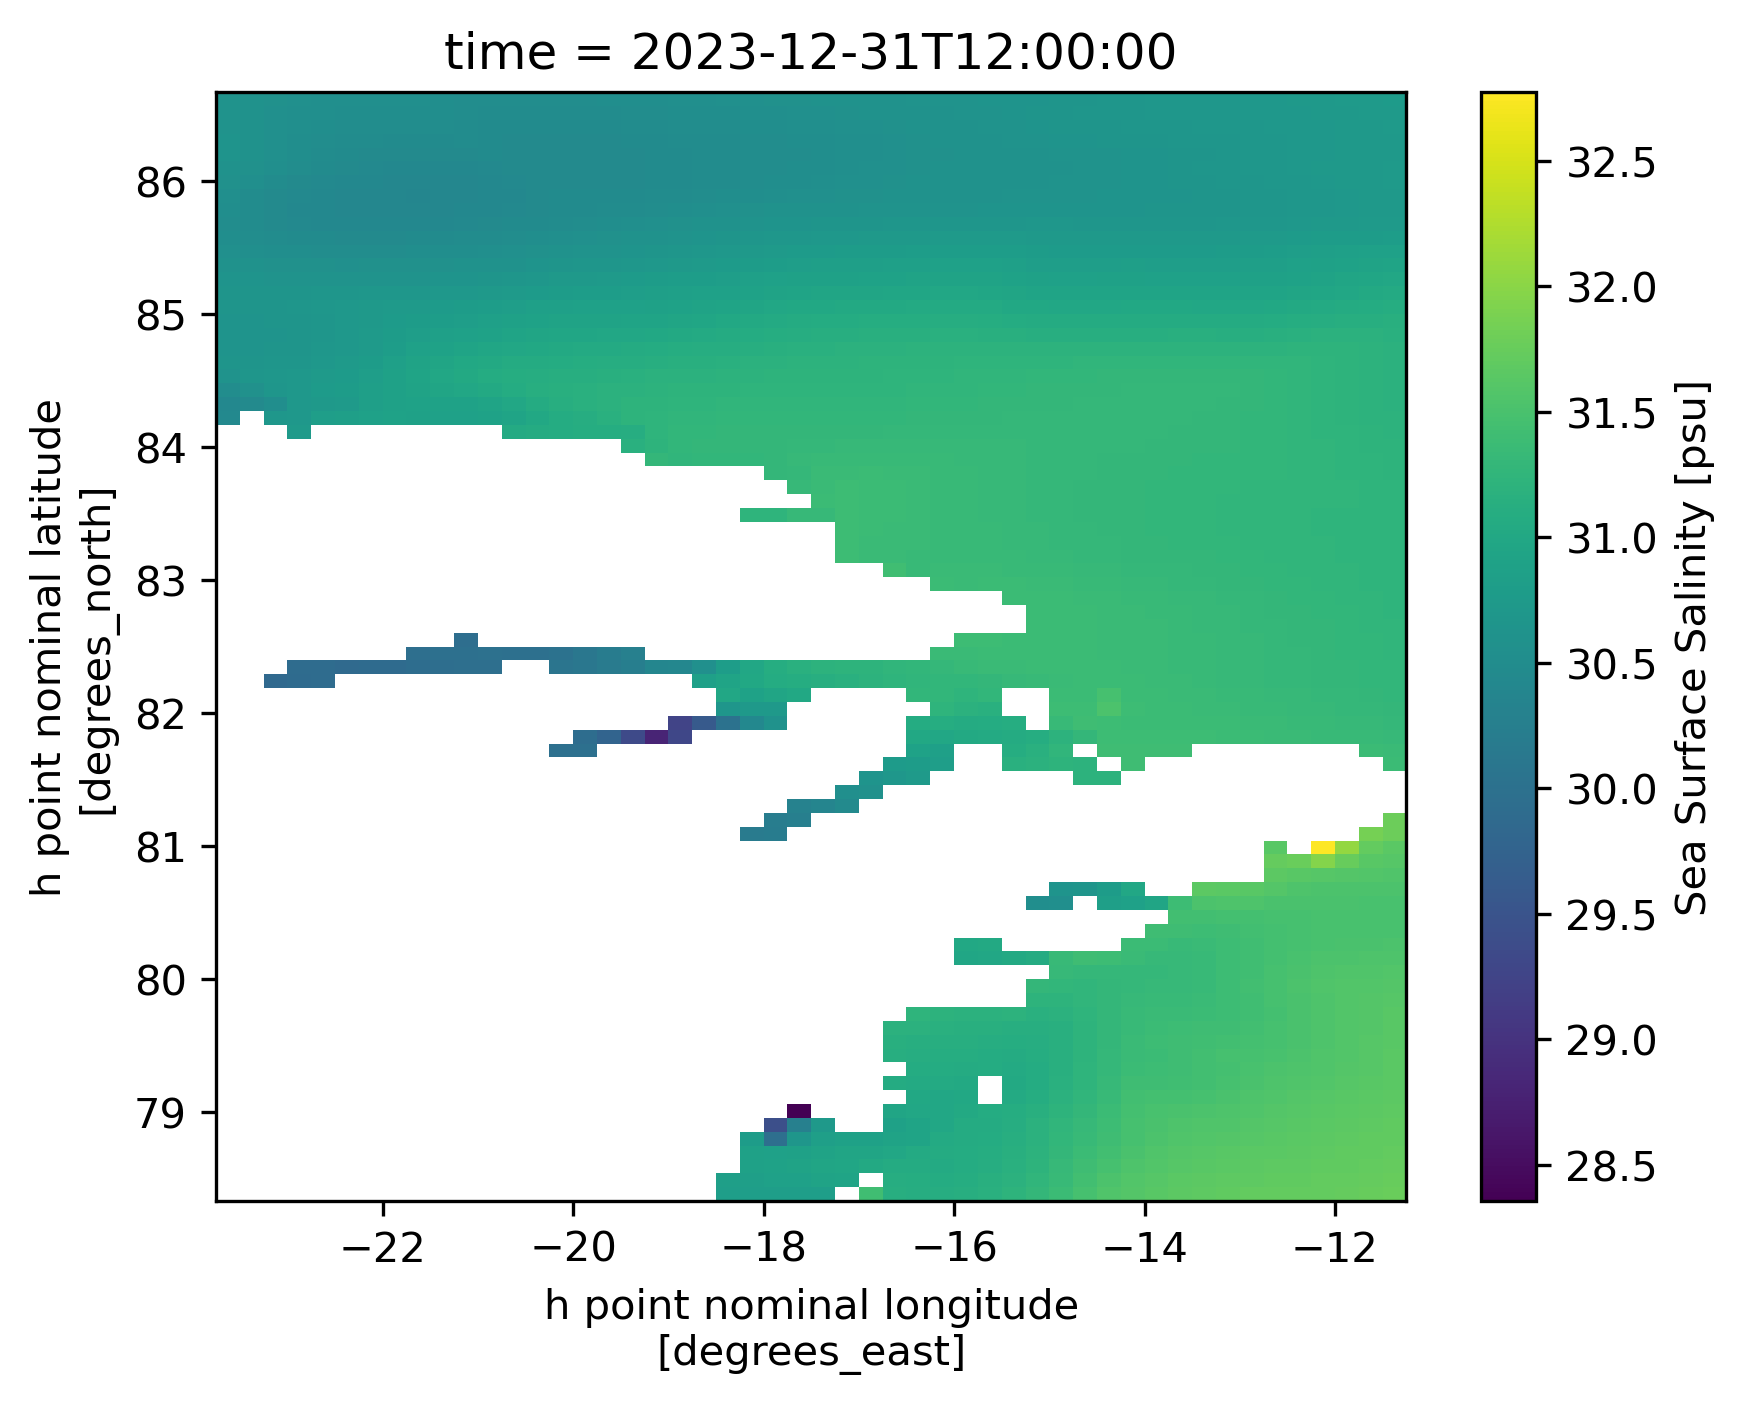

In [31]:
ocean_salt.sos.isel(time=-1, xh=slice(1025,1075), yh=slice(1040,1120)).plot()

In [18]:
depth = xr.open_dataset('/g/data/vk83/prerelease/configurations/inputs/access-om3/share/grids/global.25km/2025.09.03/topog.nc')

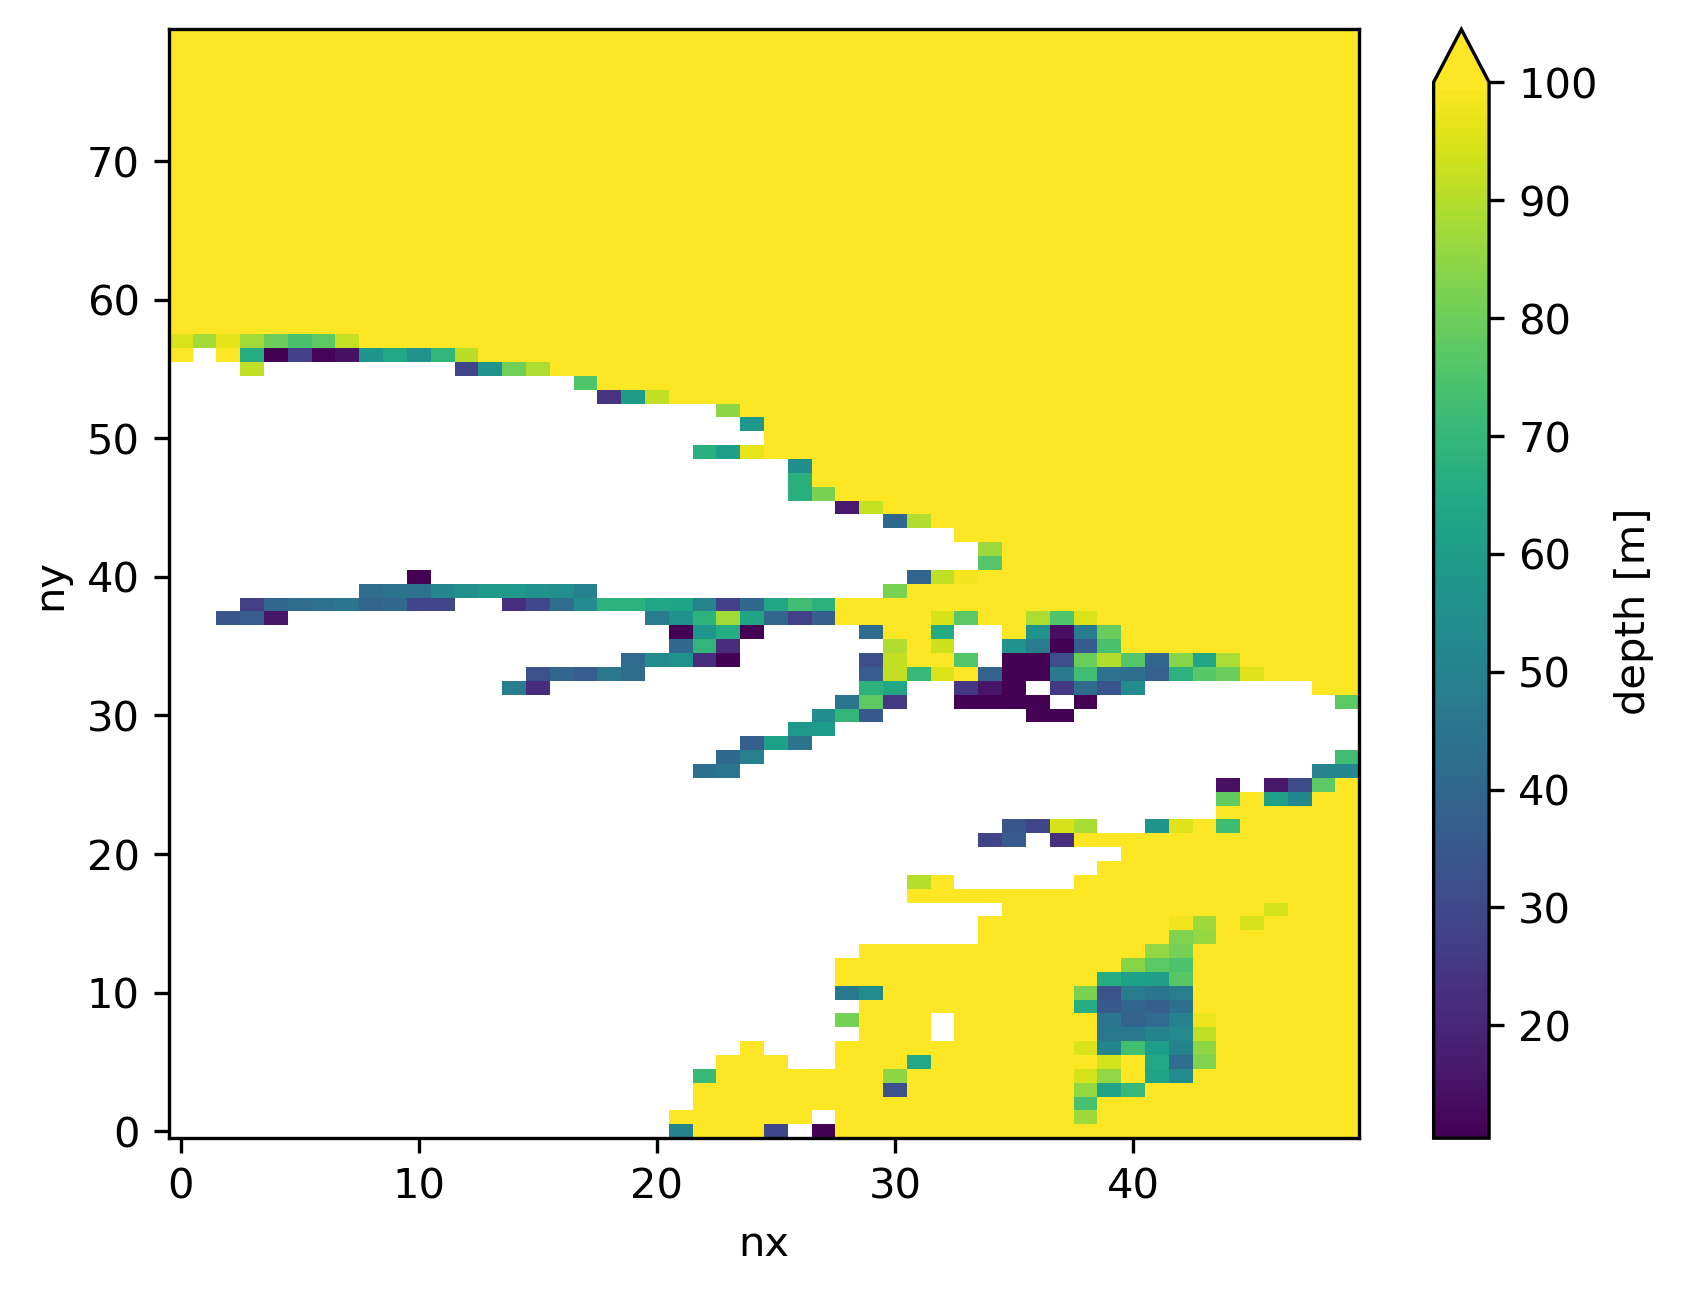

In [19]:
depth.depth.isel(nx=slice(1025,1075), ny=slice(1040,1120)).plot(vmax=100)

In [11]:
ocean_ficeberg = datastore.search(variable='ficeberg').to_dask()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [27]:
ocean_lrunoff = datastore.search(variable='lrunoff').to_dask()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 34.53 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Text(0.5, 1.0, 'Congel tendency, 12 month sum')

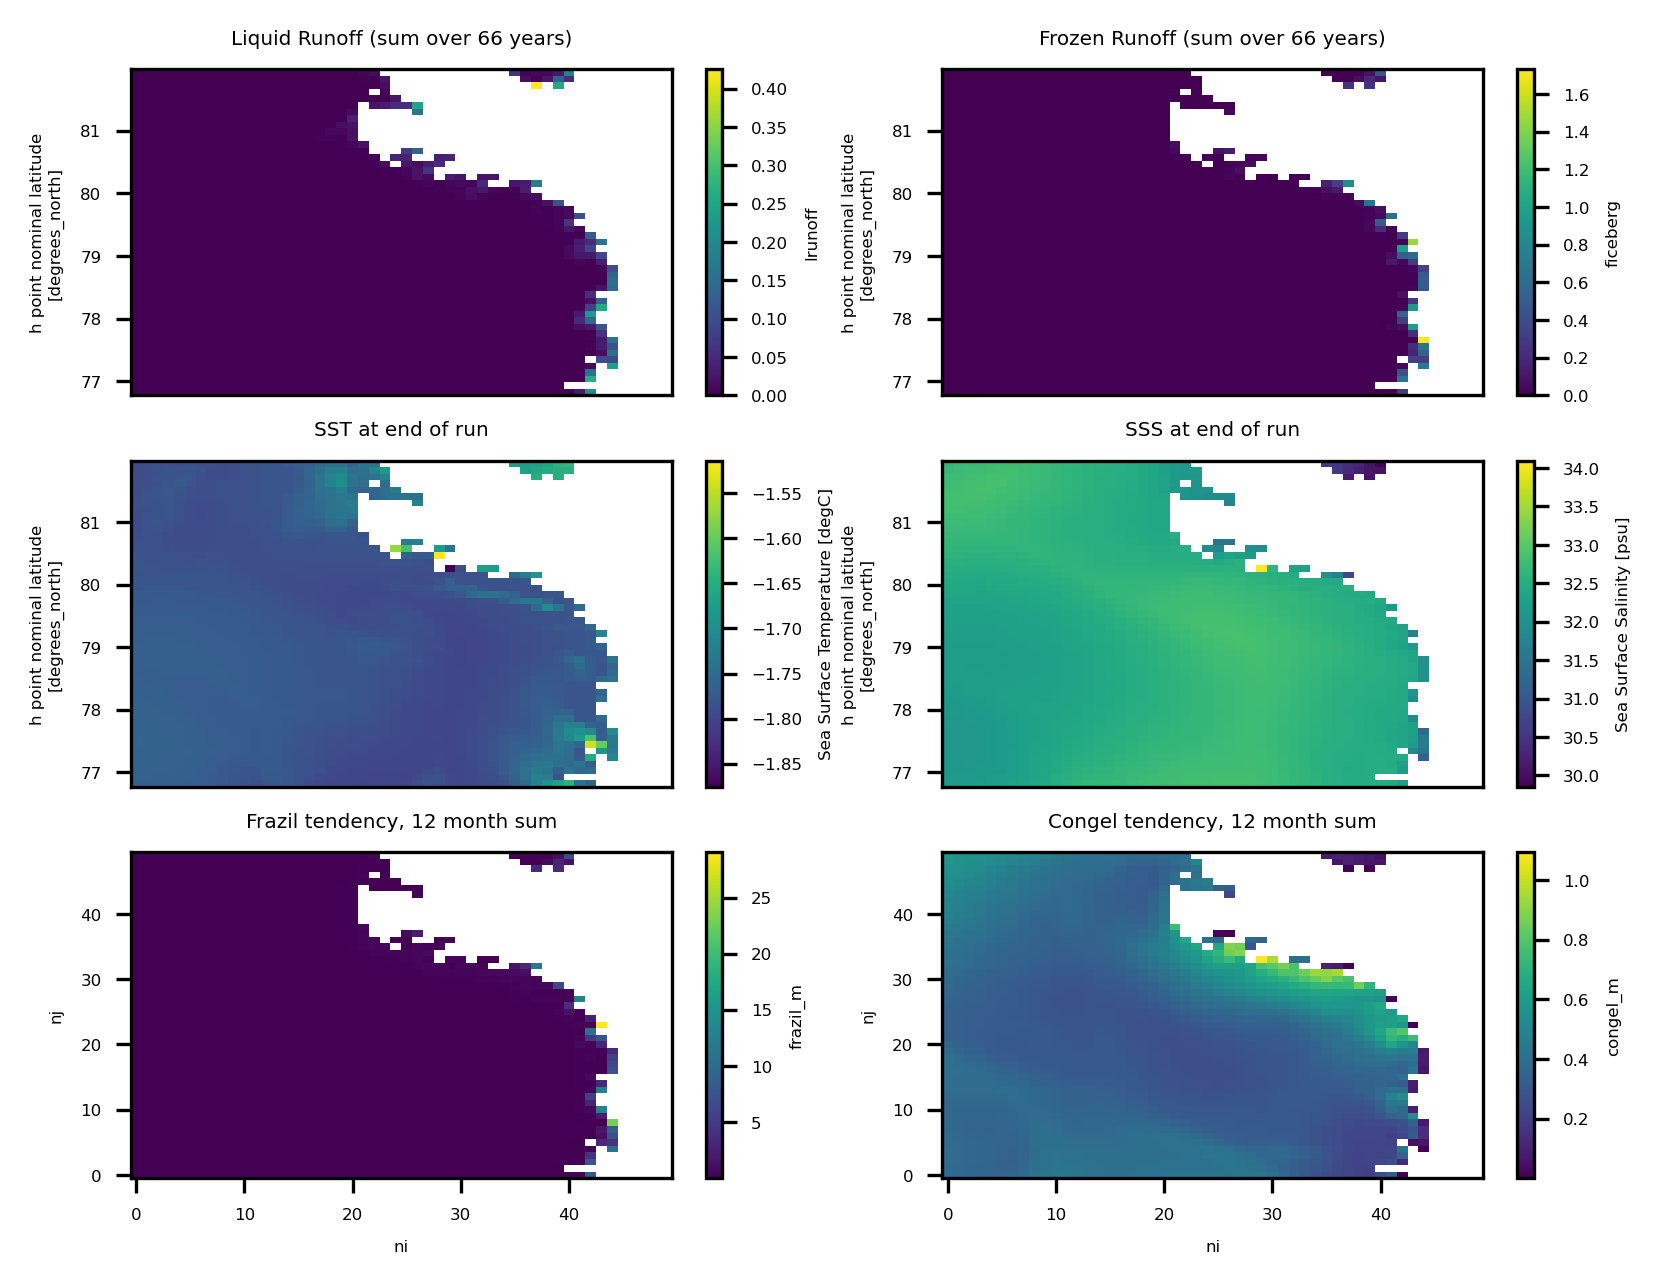

In [49]:
plt.rcParams['font.size'] = 4

xslic = slice(875,925)
yslic = slice(1025,1075)

plt.subplot(3,2,1)
ocean_lrunoff.lrunoff.isel(xh=xslic, yh=yslic).sum('time').where(ocean_ficeberg.ficeberg.isel(time=-1,drop=True).notnull()).plot()
plt.xlabel('')
plt.xticks([])
plt.title('Liquid Runoff (sum over 66 years)')

plt.subplot(3,2,2)
ocean_ficeberg.ficeberg.isel(xh=xslic, yh=yslic).sum('time').where(ocean_ficeberg.ficeberg.isel(time=-1,drop=True).notnull()).plot()
plt.xlabel('')
plt.xticks([])

plt.title('Frozen Runoff (sum over 66 years)')

plt.subplot(3,2,3)
ocean_temp.tos.isel(time=-1, xh=xslic, yh=yslic).plot()
plt.xticks([])
plt.xlabel('')
plt.title('SST at end of run')

plt.subplot(3,2,4)
ocean_salt.sos.isel(time=-1, xh=xslic, yh=yslic).plot()
plt.xticks([])
plt.xlabel('')
plt.title('SSS at end of run')


plt.subplot(3,2,5)
ds.frazil_m.isel(time=slice(-12,None),ni=xslic, nj=yslic).mean('time', skipna=False).plot() 
plt.title('Frazil tendency, 12 month sum')

plt.subplot(3,2,6)
ds.congel_m.isel(time=slice(-12,None),ni=xslic, nj=yslic).mean('time', skipna=False).plot() 
plt.title('Congel tendency, 12 month sum')


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 34.53 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Text(0.5, 1.0, 'Congel tendency, 12 month sum')

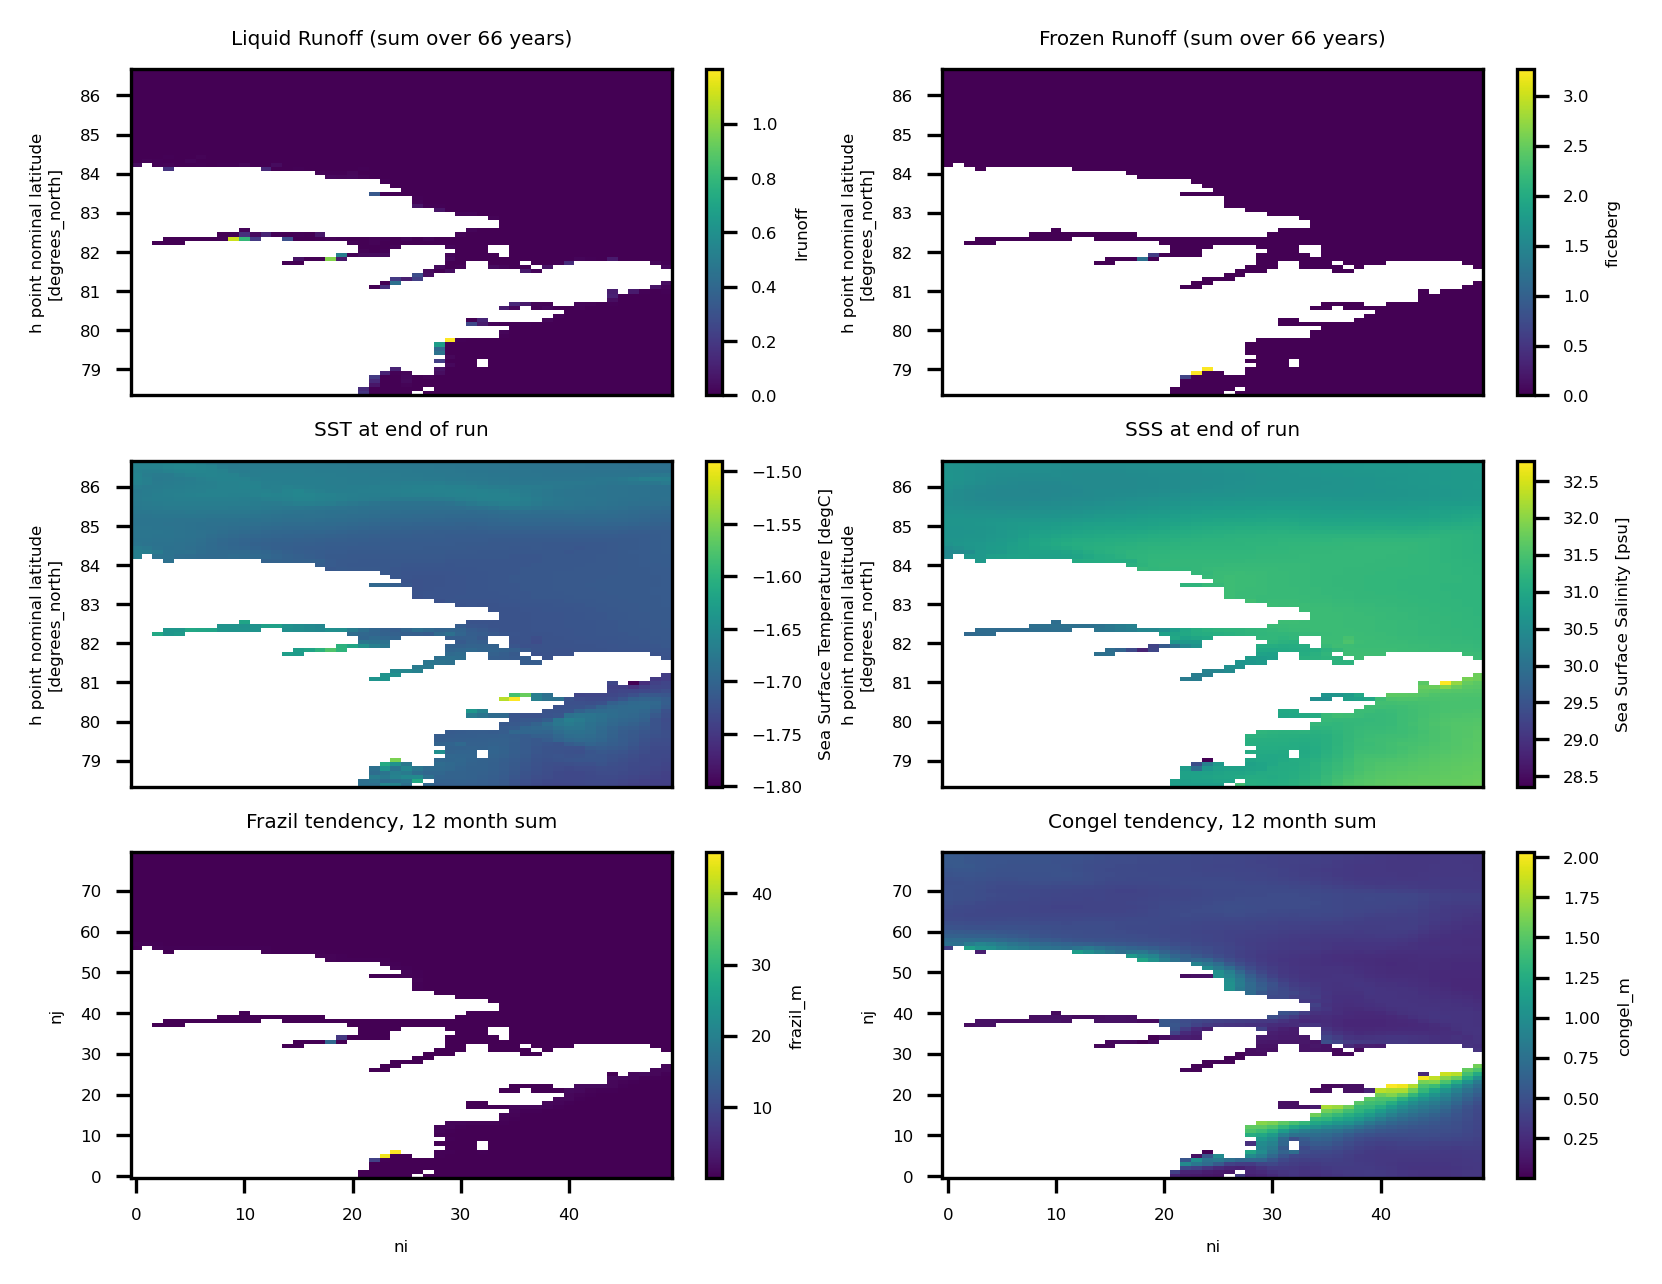

In [50]:
plt.rcParams['font.size'] = 4

xslic = slice(1025,1075)
yslic = slice(1040,1120)

plt.subplot(3,2,1)
ocean_lrunoff.lrunoff.isel(xh=xslic, yh=yslic).sum('time').where(ocean_ficeberg.ficeberg.isel(time=-1,drop=True).notnull()).plot()
plt.xlabel('')
plt.xticks([])
plt.title('Liquid Runoff (sum over 66 years)')

plt.subplot(3,2,2)
ocean_ficeberg.ficeberg.isel(xh=xslic, yh=yslic).sum('time').where(ocean_ficeberg.ficeberg.isel(time=-1,drop=True).notnull()).plot()
plt.xlabel('')
plt.xticks([])

plt.title('Frozen Runoff (sum over 66 years)')

plt.subplot(3,2,3)
ocean_temp.tos.isel(time=-1, xh=xslic, yh=yslic).plot()
plt.xticks([])
plt.xlabel('')
plt.title('SST at end of run')

plt.subplot(3,2,4)
ocean_salt.sos.isel(time=-1, xh=xslic, yh=yslic).plot()
plt.xticks([])
plt.xlabel('')
plt.title('SSS at end of run')


plt.subplot(3,2,5)
ds.frazil_m.isel(time=slice(-12,None),ni=xslic, nj=yslic).mean('time', skipna=False).plot() 
plt.title('Frazil tendency, 12 month sum')

plt.subplot(3,2,6)
ds.congel_m.isel(time=slice(-12,None),ni=xslic, nj=yslic).mean('time', skipna=False).plot() 
plt.title('Congel tendency, 12 month sum')


In [38]:
variables = ["frazil_m", "congel_m"]
ds = datastore.search(variable=variables, frequency="1mon").to_dask(
    xarray_open_kwargs = dict(chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
                              decode_timedelta=True,),
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
